# Notebook 04: LoRA Fine Tuning

- Train LoRA adaptors 

In [1]:
!pwd

/mnt/d/Study/Python Scripts/scimilarity-finetune


# Imports

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import scanpy as sc
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, f1_score
from tqdm import tqdm
import joblib
import scipy.sparse as sp
import os
from datetime import datetime
from scimilarity.nn_models import Encoder, Decoder
from tqdm import tqdm
from scimilarity.triplet_selector import TripletSelector
import torch.nn.functional as F
from app.utils import load_preprocessed_data, load_artifacts
from app.model.wrapper import load_encoder, load_decoder, load_lora_encoder
from app.logger_config import get_logger
logger = get_logger()

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)


2025-10-20 04:58:55 | logger_config.py:get_logger:41 | INFO | Logger initialized successfully.
2025-10-20 04:58:55 | logger_config.py:get_logger:41 | INFO | Logger initialized successfully.


# Load processed datasets and artifacts

In [3]:
label_encoder, _, _, _ = load_artifacts()
num_classes = len(label_encoder.classes_)
logger.info(f"number of cell types: {num_classes}")

# String label → integer
label2int = {label: i for i, label in enumerate(label_encoder.classes_)}

# Integer → string label
int2label = {i: label for i, label in enumerate(label_encoder.classes_)}

logger.info(f"Sample int2label:, {list(int2label.items())[:5]}")

2025-10-20 04:59:00 | utils.py:load_artifacts:165 | INFO | ✅ Loaded LabelEncoder, gene order, and scaling stats.
2025-10-20 04:59:00 | 4123527393.py:<module>:3 | INFO | number of cell types: 14
2025-10-20 04:59:00 | 4123527393.py:<module>:11 | INFO | Sample int2label:, [(0, 'GABAergic neuron'), (1, 'T cell'), (2, 'astrocyte'), (3, 'capillary endothelial cell'), (4, 'endothelial cell of artery')]


In [4]:
train_loader, val_loader, test_loader = load_preprocessed_data()


# Inspect a single batch
xb, yb = next(iter(test_loader))

logger.info(f"Features (xb) shape: {xb.shape}")  # [batch_size, num_genes]
logger.info(f"Labels (yb) shape: {yb.shape}")    # [batch_size]
logger.info(f"Features dtype: {xb.dtype}")
logger.info(f"Labels dtype: {yb.dtype}")

# Optional: see first 5 values of first cell
logger.info(f"First cell features (first 5 genes): {xb[0, :5]}")
logger.info(f"First cell label (encoded): {yb[0]}")
logger.info(f"First cell label (decoded): {label_encoder.inverse_transform([yb[0].item()])[0]}")

2025-10-20 04:59:50 | utils.py:load_preprocessed_data:62 | INFO | Train: (14000, 31460), Val: (3000, 31460), Test: (3000, 31460)
2025-10-20 04:59:50 | utils.py:load_artifacts:165 | INFO | ✅ Loaded LabelEncoder, gene order, and scaling stats.
2025-10-20 04:59:51 | 2481640480.py:<module>:7 | INFO | Features (xb) shape: torch.Size([1024, 31460])
2025-10-20 04:59:51 | 2481640480.py:<module>:8 | INFO | Labels (yb) shape: torch.Size([1024])
2025-10-20 04:59:51 | 2481640480.py:<module>:9 | INFO | Features dtype: torch.float32
2025-10-20 04:59:51 | 2481640480.py:<module>:10 | INFO | Labels dtype: torch.int64
2025-10-20 04:59:51 | 2481640480.py:<module>:13 | INFO | First cell features (first 5 genes): tensor([0., 0., 0., 0., 0.])
2025-10-20 04:59:51 | 2481640480.py:<module>:14 | INFO | First cell label (encoded): 8
2025-10-20 04:59:51 | 2481640480.py:<module>:15 | INFO | First cell label (decoded): oligodendrocyte


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

# Load lora encoder and decoder

In [7]:
n_genes = xb.shape[1]
hidden_dim = 1024
logger.info(f"Number of genes (input features): {n_genes}")

2025-10-20 05:00:09 | 3468877492.py:<module>:3 | INFO | Number of genes (input features): 31460


In [8]:
decoder = load_decoder(n_genes)

In [9]:
encoder_lora = load_lora_encoder(n_genes=n_genes, hidden_dim=hidden_dim)

In [10]:
# Helper function to count parameters
def count_params(model):
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    pct_trainable = 100 * trainable / total
    return total, trainable, pct_trainable

# Count params for encoder (LoRA) and decoder (frozen)
total_encoder, trainable_encoder, _ = count_params(encoder_lora)
total_decoder, trainable_decoder, _ = count_params(decoder)  # usually frozen

# Total params (encoder + decoder)
total_params = total_encoder + total_decoder

# Total trainable params (LoRA only)
trainable_params = trainable_encoder

# Percentage of trainable params
pct_trainable = 100 * trainable_params / total_params

logger.info(f"Encoder ({total_encoder:,}) + Decoder ({total_decoder:,}) total params: {total_params:,}")
logger.info(f"Trainable params (LoRA only): {trainable_params:,}")
logger.info(f"Percentage of trainable params: {pct_trainable:.2f}%")

2025-10-20 05:00:18 | 2957559303.py:<module>:21 | INFO | Encoder (33,971,906) + Decoder (33,432,294) total params: 67,404,200
2025-10-20 05:00:18 | 2957559303.py:<module>:22 | INFO | Trainable params (LoRA only): 570,944
2025-10-20 05:00:18 | 2957559303.py:<module>:23 | INFO | Percentage of trainable params: 0.85%


In [11]:
device

device(type='cpu')

In [13]:

# --- 1️⃣ Custom Triplet Selector (non-batch version) ---
class CustomTripletSelector:
    def __init__(self, margin=0.05):
        self.margin = margin

    def get_triplets_idx(self, embeddings, labels):
        """Generate triplet indices (anchor, positive, negative) for all embeddings."""
        embeddings = embeddings.cpu()
        labels = labels.cpu()
        n = len(labels)
        anchor_idx, pos_idx, neg_idx = [], [], []

        # Compute pairwise distances
        dist_matrix = torch.cdist(embeddings, embeddings, p=2)

        for i in range(n):
            label = labels[i]
            pos_mask = (labels == label) & (torch.arange(n) != i)
            neg_mask = labels != label

            if not pos_mask.any() or not neg_mask.any():
                continue

            pos_dists = dist_matrix[i][pos_mask]
            neg_dists = dist_matrix[i][neg_mask]

            # Semi-hard negative selection: d(a,n) > d(a,p) and within margin
            pos_dist = torch.min(pos_dists)
            neg_candidates = torch.where((neg_dists > pos_dist) & (neg_dists < pos_dist + self.margin))[0]

            if len(neg_candidates) > 0:
                neg_idx_sel = neg_candidates[torch.randint(0, len(neg_candidates), (1,))].item()
            else:
                # fallback: hardest negative
                neg_idx_sel = torch.argmin(neg_dists).item()

            pos_idx_sel = torch.where(pos_mask)[0][torch.randint(0, pos_mask.sum(), (1,))].item()

            anchor_idx.append(i)
            pos_idx.append(pos_idx_sel)
            neg_idx.append(neg_idx_sel)

        return torch.tensor(anchor_idx), torch.tensor(pos_idx), torch.tensor(neg_idx)

# --- 2️⃣ Hyperparameters ---
lr = 1e-3
num_epochs = 25
margin = 0.05
triplet_selector = CustomTripletSelector(margin=margin)

# --- 3️⃣ Optimizer: only LoRA params ---
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, encoder_lora.parameters()), lr=lr)

# --- 4️⃣ Save directory ---
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
save_dir = f"weights/lora/{timestamp}"
os.makedirs(save_dir, exist_ok=True)


train_triplet_losses, train_recon_losses = [], []
val_triplet_losses, val_recon_losses = [], []

# --- Training Loop ---
for epoch in range(num_epochs):
    encoder_lora.train()
    total_triplet_loss = 0.0
    total_recon_loss = 0.0

    for xb, yb in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        xb = xb.to(device)
        yb = yb.to(device)

        # Forward
        emb = encoder_lora(xb)
        xb_recon = decoder(emb)

        # Triplets
        a_idx, p_idx, n_idx = triplet_selector.get_triplets_idx(emb.detach(), yb.detach())
        if len(a_idx) == 0:
            continue

        anchor = emb[a_idx]
        positive = emb[p_idx]
        negative = emb[n_idx]
        triplet_loss_fn = torch.nn.TripletMarginLoss(margin=margin, reduction="mean")
        loss_triplet = triplet_loss_fn(anchor, positive, negative)
        loss_recon = F.mse_loss(xb_recon, xb)
        loss = loss_triplet + loss_recon

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_triplet_loss += loss_triplet.item()
        total_recon_loss += loss_recon.item()

    # --- 1️⃣ Validation & Embeddings ---
    encoder_lora.eval()
    def get_embeddings_and_labels(loader):
        all_emb, all_lbl = [], []
        total_triplet, total_recon = 0.0, 0.0
        with torch.no_grad():
            for xb, yb in loader:
                xb = xb.to(device)
                yb = yb.to(device)

                emb = encoder_lora(xb)
                xb_recon = decoder(emb)

                # Triplets
                a_idx, p_idx, n_idx = triplet_selector.get_triplets_idx(emb, yb)
                if len(a_idx) > 0:
                    anchor = emb[a_idx]
                    positive = emb[p_idx]
                    negative = emb[n_idx]
                    loss_triplet = triplet_loss_fn(anchor, positive, negative)
                    loss_recon = F.mse_loss(xb_recon, xb)
                    total_triplet += loss_triplet.item()
                    total_recon += loss_recon.item()

                all_emb.append(emb.cpu())
                all_lbl.append(yb.cpu())

        return torch.cat(all_emb), torch.cat(all_lbl), total_triplet, total_recon

    train_emb, train_lbl, train_triplet_val, train_recon_val = get_embeddings_and_labels(train_loader)
    val_emb, val_lbl, val_triplet_loss, val_recon_loss = get_embeddings_and_labels(val_loader)

    # --- 2️⃣ KNN evaluation ---
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.metrics import accuracy_score, f1_score

    knn = KNeighborsClassifier(n_neighbors=5)
    knn.fit(train_emb, train_lbl)

    train_pred = knn.predict(train_emb)
    val_pred = knn.predict(val_emb)

    train_acc = accuracy_score(train_lbl, train_pred) * 100
    val_acc = accuracy_score(val_lbl, val_pred) * 100
    train_f1 = f1_score(train_lbl, train_pred, average="weighted")
    val_f1 = f1_score(val_lbl, val_pred, average="weighted")

    avg_train_triplet = total_triplet_loss / len(train_loader)
    avg_train_recon = total_recon_loss / len(train_loader)
    avg_val_triplet = val_triplet_loss / len(val_loader)
    avg_val_recon = val_recon_loss / len(val_loader)

    # --- 3️⃣ Print Stats ---
    print(f"\nEpoch [{epoch+1}/{num_epochs}]")
    print(f"  Train Triplet Loss: {avg_train_triplet:.4f}, Recon Loss: {avg_train_recon:.4f}")
    print(f"  Val   Triplet Loss: {avg_val_triplet:.4f}, Recon Loss: {avg_val_recon:.4f}")
    print(f"  Train Acc: {train_acc:.2f} %, F1: {train_f1:.4f}")
    print(f"  Val   Acc: {val_acc:.2f} %, F1: {val_f1:.4f}")

    # --- Save losses for plotting ---
    train_triplet_losses.append(avg_train_triplet)
    train_recon_losses.append(avg_train_recon)
    val_triplet_losses.append(avg_val_triplet)
    val_recon_losses.append(avg_val_recon)

    # --- 4️⃣ Save LoRA weights only ---
    lora_weights = {k: v.cpu() for k, v in encoder_lora.lora_params.items()}
    torch.save(lora_weights, os.path.join(save_dir, f"lora_epoch{epoch+1}.pt"))
    print(f"  ✅ Saved LoRA weights to {save_dir}/lora_epoch{epoch+1}.pt\n")



Epoch 1/25:   0%|                                                                                    | 0/14 [00:00<?, ?it/s]

Epoch 1/25: 100%|███████████████████████████████████████████████████████████████████████████| 14/14 [00:36<00:00,  2.62s/it]



Epoch [1/25]
  Train Triplet Loss: 0.3104, Recon Loss: 0.6834
  Val   Triplet Loss: 0.0855, Recon Loss: 0.1806
  Train Acc: 56.91 %, F1: 0.5729
  Val   Acc: 17.80 %, F1: 0.1440
  ✅ Saved LoRA weights to weights/lora/20251020_050117/lora_epoch1.pt



Epoch 2/25: 100%|███████████████████████████████████████████████████████████████████████████| 14/14 [00:34<00:00,  2.50s/it]



Epoch [2/25]
  Train Triplet Loss: 0.2697, Recon Loss: 0.6630
  Val   Triplet Loss: 0.1091, Recon Loss: 0.1823
  Train Acc: 64.10 %, F1: 0.6394
  Val   Acc: 27.27 %, F1: 0.2545
  ✅ Saved LoRA weights to weights/lora/20251020_050117/lora_epoch2.pt



Epoch 3/25: 100%|███████████████████████████████████████████████████████████████████████████| 14/14 [00:33<00:00,  2.42s/it]



Epoch [3/25]
  Train Triplet Loss: 0.1971, Recon Loss: 0.6516
  Val   Triplet Loss: 0.0980, Recon Loss: 0.1820
  Train Acc: 73.17 %, F1: 0.7277
  Val   Acc: 45.03 %, F1: 0.4267
  ✅ Saved LoRA weights to weights/lora/20251020_050117/lora_epoch3.pt



Epoch 4/25: 100%|███████████████████████████████████████████████████████████████████████████| 14/14 [00:34<00:00,  2.45s/it]



Epoch [4/25]
  Train Triplet Loss: 0.1229, Recon Loss: 0.6414
  Val   Triplet Loss: 0.0954, Recon Loss: 0.1804
  Train Acc: 75.59 %, F1: 0.7493
  Val   Acc: 50.27 %, F1: 0.4673
  ✅ Saved LoRA weights to weights/lora/20251020_050117/lora_epoch4.pt



Epoch 5/25: 100%|███████████████████████████████████████████████████████████████████████████| 14/14 [00:36<00:00,  2.59s/it]



Epoch [5/25]
  Train Triplet Loss: 0.0933, Recon Loss: 0.6315
  Val   Triplet Loss: 0.0864, Recon Loss: 0.1785
  Train Acc: 77.58 %, F1: 0.7699
  Val   Acc: 50.13 %, F1: 0.4618
  ✅ Saved LoRA weights to weights/lora/20251020_050117/lora_epoch5.pt



Epoch 6/25: 100%|███████████████████████████████████████████████████████████████████████████| 14/14 [00:34<00:00,  2.44s/it]



Epoch [6/25]
  Train Triplet Loss: 0.0711, Recon Loss: 0.6251
  Val   Triplet Loss: 0.0652, Recon Loss: 0.1772
  Train Acc: 77.71 %, F1: 0.7720
  Val   Acc: 53.17 %, F1: 0.4957
  ✅ Saved LoRA weights to weights/lora/20251020_050117/lora_epoch6.pt



Epoch 7/25: 100%|███████████████████████████████████████████████████████████████████████████| 14/14 [00:33<00:00,  2.41s/it]



Epoch [7/25]
  Train Triplet Loss: 0.0574, Recon Loss: 0.6222
  Val   Triplet Loss: 0.0490, Recon Loss: 0.1773
  Train Acc: 78.88 %, F1: 0.7844
  Val   Acc: 55.33 %, F1: 0.5159
  ✅ Saved LoRA weights to weights/lora/20251020_050117/lora_epoch7.pt



Epoch 8/25: 100%|███████████████████████████████████████████████████████████████████████████| 14/14 [00:34<00:00,  2.45s/it]



Epoch [8/25]
  Train Triplet Loss: 0.0491, Recon Loss: 0.6206
  Val   Triplet Loss: 0.0419, Recon Loss: 0.1769
  Train Acc: 79.50 %, F1: 0.7905
  Val   Acc: 56.73 %, F1: 0.5309
  ✅ Saved LoRA weights to weights/lora/20251020_050117/lora_epoch8.pt



Epoch 9/25: 100%|███████████████████████████████████████████████████████████████████████████| 14/14 [00:33<00:00,  2.42s/it]



Epoch [9/25]
  Train Triplet Loss: 0.0397, Recon Loss: 0.6194
  Val   Triplet Loss: 0.0353, Recon Loss: 0.1766
  Train Acc: 80.27 %, F1: 0.7990
  Val   Acc: 57.33 %, F1: 0.5425
  ✅ Saved LoRA weights to weights/lora/20251020_050117/lora_epoch9.pt



Epoch 10/25: 100%|██████████████████████████████████████████████████████████████████████████| 14/14 [00:34<00:00,  2.45s/it]



Epoch [10/25]
  Train Triplet Loss: 0.0359, Recon Loss: 0.6189
  Val   Triplet Loss: 0.0311, Recon Loss: 0.1764
  Train Acc: 80.44 %, F1: 0.8002
  Val   Acc: 56.63 %, F1: 0.5349
  ✅ Saved LoRA weights to weights/lora/20251020_050117/lora_epoch10.pt



Epoch 11/25: 100%|██████████████████████████████████████████████████████████████████████████| 14/14 [00:34<00:00,  2.46s/it]



Epoch [11/25]
  Train Triplet Loss: 0.0331, Recon Loss: 0.6185
  Val   Triplet Loss: 0.0338, Recon Loss: 0.1766
  Train Acc: 81.04 %, F1: 0.8066
  Val   Acc: 58.47 %, F1: 0.5553
  ✅ Saved LoRA weights to weights/lora/20251020_050117/lora_epoch11.pt



Epoch 12/25: 100%|██████████████████████████████████████████████████████████████████████████| 14/14 [00:33<00:00,  2.43s/it]



Epoch [12/25]
  Train Triplet Loss: 0.0302, Recon Loss: 0.6185
  Val   Triplet Loss: 0.0268, Recon Loss: 0.1763
  Train Acc: 80.98 %, F1: 0.8056
  Val   Acc: 57.20 %, F1: 0.5412
  ✅ Saved LoRA weights to weights/lora/20251020_050117/lora_epoch12.pt



Epoch 13/25: 100%|██████████████████████████████████████████████████████████████████████████| 14/14 [00:34<00:00,  2.44s/it]



Epoch [13/25]
  Train Triplet Loss: 0.0277, Recon Loss: 0.6182
  Val   Triplet Loss: 0.0256, Recon Loss: 0.1762
  Train Acc: 81.75 %, F1: 0.8136
  Val   Acc: 57.40 %, F1: 0.5421
  ✅ Saved LoRA weights to weights/lora/20251020_050117/lora_epoch13.pt



Epoch 14/25: 100%|██████████████████████████████████████████████████████████████████████████| 14/14 [00:34<00:00,  2.45s/it]



Epoch [14/25]
  Train Triplet Loss: 0.0267, Recon Loss: 0.6177
  Val   Triplet Loss: 0.0253, Recon Loss: 0.1763
  Train Acc: 82.14 %, F1: 0.8185
  Val   Acc: 57.57 %, F1: 0.5461
  ✅ Saved LoRA weights to weights/lora/20251020_050117/lora_epoch14.pt



Epoch 15/25: 100%|██████████████████████████████████████████████████████████████████████████| 14/14 [00:33<00:00,  2.42s/it]



Epoch [15/25]
  Train Triplet Loss: 0.0261, Recon Loss: 0.6181
  Val   Triplet Loss: 0.0266, Recon Loss: 0.1762
  Train Acc: 81.93 %, F1: 0.8158
  Val   Acc: 57.90 %, F1: 0.5524
  ✅ Saved LoRA weights to weights/lora/20251020_050117/lora_epoch15.pt



Epoch 16/25: 100%|██████████████████████████████████████████████████████████████████████████| 14/14 [00:33<00:00,  2.42s/it]



Epoch [16/25]
  Train Triplet Loss: 0.0245, Recon Loss: 0.6180
  Val   Triplet Loss: 0.0221, Recon Loss: 0.1762
  Train Acc: 82.16 %, F1: 0.8177
  Val   Acc: 59.17 %, F1: 0.5629
  ✅ Saved LoRA weights to weights/lora/20251020_050117/lora_epoch16.pt



Epoch 17/25: 100%|██████████████████████████████████████████████████████████████████████████| 14/14 [00:35<00:00,  2.54s/it]



Epoch [17/25]
  Train Triplet Loss: 0.0217, Recon Loss: 0.6181
  Val   Triplet Loss: 0.0216, Recon Loss: 0.1762
  Train Acc: 82.75 %, F1: 0.8246
  Val   Acc: 58.93 %, F1: 0.5617
  ✅ Saved LoRA weights to weights/lora/20251020_050117/lora_epoch17.pt



Epoch 18/25: 100%|██████████████████████████████████████████████████████████████████████████| 14/14 [00:34<00:00,  2.47s/it]



Epoch [18/25]
  Train Triplet Loss: 0.0248, Recon Loss: 0.6181
  Val   Triplet Loss: 0.0205, Recon Loss: 0.1762
  Train Acc: 83.31 %, F1: 0.8301
  Val   Acc: 59.17 %, F1: 0.5674
  ✅ Saved LoRA weights to weights/lora/20251020_050117/lora_epoch18.pt



Epoch 19/25: 100%|██████████████████████████████████████████████████████████████████████████| 14/14 [00:34<00:00,  2.43s/it]



Epoch [19/25]
  Train Triplet Loss: 0.0218, Recon Loss: 0.6176
  Val   Triplet Loss: 0.0201, Recon Loss: 0.1762
  Train Acc: 83.59 %, F1: 0.8332
  Val   Acc: 59.60 %, F1: 0.5728
  ✅ Saved LoRA weights to weights/lora/20251020_050117/lora_epoch19.pt



Epoch 20/25: 100%|██████████████████████████████████████████████████████████████████████████| 14/14 [00:33<00:00,  2.42s/it]



Epoch [20/25]
  Train Triplet Loss: 0.0217, Recon Loss: 0.6175
  Val   Triplet Loss: 0.0186, Recon Loss: 0.1763
  Train Acc: 83.61 %, F1: 0.8333
  Val   Acc: 61.67 %, F1: 0.5938
  ✅ Saved LoRA weights to weights/lora/20251020_050117/lora_epoch20.pt



Epoch 21/25: 100%|██████████████████████████████████████████████████████████████████████████| 14/14 [00:33<00:00,  2.42s/it]



Epoch [21/25]
  Train Triplet Loss: 0.0203, Recon Loss: 0.6176
  Val   Triplet Loss: 0.0182, Recon Loss: 0.1762
  Train Acc: 83.81 %, F1: 0.8353
  Val   Acc: 61.93 %, F1: 0.5951
  ✅ Saved LoRA weights to weights/lora/20251020_050117/lora_epoch21.pt



Epoch 22/25: 100%|██████████████████████████████████████████████████████████████████████████| 14/14 [00:33<00:00,  2.41s/it]



Epoch [22/25]
  Train Triplet Loss: 0.0208, Recon Loss: 0.6180
  Val   Triplet Loss: 0.0170, Recon Loss: 0.1762
  Train Acc: 84.39 %, F1: 0.8410
  Val   Acc: 61.30 %, F1: 0.5875
  ✅ Saved LoRA weights to weights/lora/20251020_050117/lora_epoch22.pt



Epoch 23/25: 100%|██████████████████████████████████████████████████████████████████████████| 14/14 [00:33<00:00,  2.38s/it]



Epoch [23/25]
  Train Triplet Loss: 0.0191, Recon Loss: 0.6178
  Val   Triplet Loss: 0.0168, Recon Loss: 0.1762
  Train Acc: 84.66 %, F1: 0.8442
  Val   Acc: 62.23 %, F1: 0.5996
  ✅ Saved LoRA weights to weights/lora/20251020_050117/lora_epoch23.pt



Epoch 24/25: 100%|██████████████████████████████████████████████████████████████████████████| 14/14 [00:33<00:00,  2.37s/it]



Epoch [24/25]
  Train Triplet Loss: 0.0198, Recon Loss: 0.6178
  Val   Triplet Loss: 0.0162, Recon Loss: 0.1761
  Train Acc: 85.36 %, F1: 0.8513
  Val   Acc: 62.27 %, F1: 0.5976
  ✅ Saved LoRA weights to weights/lora/20251020_050117/lora_epoch24.pt



Epoch 25/25: 100%|██████████████████████████████████████████████████████████████████████████| 14/14 [00:33<00:00,  2.42s/it]



Epoch [25/25]
  Train Triplet Loss: 0.0189, Recon Loss: 0.6179
  Val   Triplet Loss: 0.0166, Recon Loss: 0.1762
  Train Acc: 85.74 %, F1: 0.8550
  Val   Acc: 61.30 %, F1: 0.5846
  ✅ Saved LoRA weights to weights/lora/20251020_050117/lora_epoch25.pt



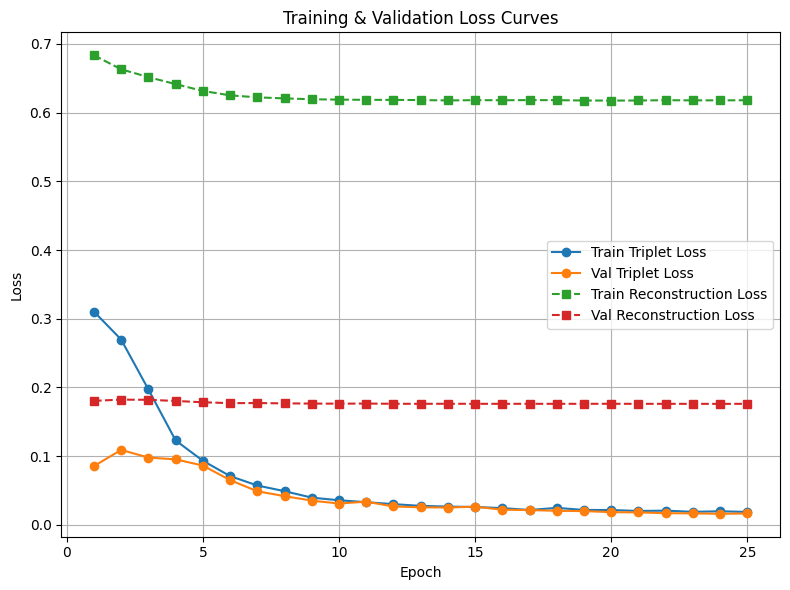

In [17]:
# --- Plot losses ---
plt.figure(figsize=(8, 6))
epochs = range(1, len(train_triplet_losses) + 1)
plt.plot(epochs, train_triplet_losses, label="Train Triplet Loss", marker='o')
plt.plot(epochs, val_triplet_losses, label="Val Triplet Loss", marker='o')
plt.plot(epochs, train_recon_losses, label="Train Reconstruction Loss", linestyle="--", marker='s')
plt.plot(epochs, val_recon_losses, label="Val Reconstruction Loss", linestyle="--", marker='s')

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training & Validation Loss Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# **Observations**

- **Train Triplet Loss**:

  - Starts around **0.3** and decreases rapidly within the first **5 epochs**.
  - Continues to decrease smoothly and plateaus near **0.02** after about **10 epochs**.
  - Indicates good convergence and stable training.

- **Validation Triplet Loss**:

  - Follows a similar decreasing trend as the training loss.
  - Shows **no signs of overfitting** (no divergence between train and val losses).

- **Train Reconstruction Loss**:

  - Starts around **0.68** and decreases slightly to about **0.62**, then stabilizes.
  - The small reduction suggests the reconstruction part of the model is not learning much after early epochs.

- **Validation Reconstruction Loss**:

  - Remains almost constant around **0.18**, indicating stability but possibly limited generalization improvement.


# **Conclusions**

- The **triplet loss component** shows strong and smooth convergence, the model is effectively learning discriminative embeddings.
- The **reconstruction loss** plateaus early, indicating that the reconstruction task might have reached its capacity or is less dominant in the training objective.
- There is **no visible overfitting** in both training and validation losses are aligned and stable after ~10 epochs.
- After **10th** epoch, both training and validation triplet losses have converged and show minimal improvement.
- So, we will use **10th** epoch model for inference
